In [1]:
# -*- coding: utf-8 -*-
from keras.models import Sequential
from keras import backend as K
from keras import layers
from keras.layers import Dense, Dropout, Flatten
from keras.initializers import RandomNormal
from keras.optimizers import Adam
from feature_selection import FeatureSelection

from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

Using TensorFlow backend.
/Users/kohei_wakamatsu/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
# load data
train  = pd.read_csv('dataset/gene-expression/data_set_ALL_AML_train.csv')
test   = pd.read_csv('dataset/gene-expression/data_set_ALL_AML_independent.csv')
actual = pd.read_csv('dataset/gene-expression/actual.csv')

X_train = train.loc[:, [e for e in train.columns if 'call' not in e]].drop(['Gene Description', 'Gene Accession Number'], axis=1).T
X_test  = test.loc[:, [e for e in test.columns if 'call' not in e]].drop(['Gene Description', 'Gene Accession Number'], axis=1).T.sort_index()
X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)

# normarize
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test  = scaler.transform(X_test)
X_train = np.array(X_train).reshape(38, 7129, 1)
X_test  = np.array(X_test).reshape(34, 7129, 1)

obj_class = 1 * (actual['cancer'] == 'AML')
y_train = np.eye(2)[obj_class][:38]
y_test  = np.eye(2)[obj_class][38:]

In [3]:
# define model
def all_aml_model():
    model = Sequential()
    
    model.add(FeatureSelection(input_shape=(7129, 1)))
    model.add(Flatten())
              
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.25))
    
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.25))
              
    model.add(Dense(2, activation='softmax'))
    model.compile(loss='categorical_crossentropy',
                  optimizer=Adam(),
                  metrics=['accuracy'])
    
    return model

In [4]:
model = all_aml_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
feature_selection_1 (Feature (None, 7129, 1)           7129      
_________________________________________________________________
flatten_1 (Flatten)          (None, 7129)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                228160    
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 66        
Total para

In [5]:
# execute learning 50 times
fs_weights50 = []
score50 = []

for i in range(50):
    model = all_aml_model()
    model.fit(X_train, y_train,
              batch_size=38,
              epochs=100,
              verbose=0)
    score50.append(model.evaluate(X_test, y_test, batch_size=34))
    fs_weights50.append(model.get_weights()[0])

34/34 [==============================] - 1s 21ms/step


In [6]:
# check result
fs_weights_arr = np.array(fs_weights50)
fs_mean = fs_weights_arr.mean(axis=0)
print("mean of 50 times : {}".format(fs_mean))

# make sorted dataframe
df_res = pd.DataFrame()
df_res['abs fs weight'] = abs(fs_mean.reshape(7129))
df_res['gene no.'] = train['Gene Accession Number']

df_sorted = df_res.sort_values(by='abs fs weight', ascending=False)

mean of 50 times : [[-0.00235489]
 [ 0.00328615]
 [ 0.00158957]
 ..., 
 [-0.00832619]
 [-0.01673643]
 [ 0.00897822]]


In [7]:
# check result
df_sorted

abs fs weight                 gene no.
4479   6.058640e-02                X69111_at
1259   3.549667e-02                L09717_at
2275   3.508720e-02                M83233_at
1912   3.314180e-02                M29971_at
2393   3.306646e-02                M95678_at
3003   3.279086e-02                U29656_at
3807   3.247274e-02                U80073_at
3390   3.186455e-02                U53468_at
5584   3.169151e-02              U00802_s_at
6199   3.153386e-02         M28130_rna1_s_at
3574   3.152033e-02                U66468_at
3      3.120945e-02           AFFX-BioC-5_at
1697   3.119775e-02                M13207_at
2287   3.094876e-02                M84526_at
4196   3.065741e-02                X17094_at
5809   3.061672e-02       HG2981-HT3125_s_at
5759   3.027799e-02       HG2479-HT2575_s_at
53     3.019799e-02  AFFX-HSAC07/X00351_3_st
602    2.938781e-02                D82345_at
5665   2.933011e-02              D78577_s_at
4088   2.922792e-02                X06482_at
3800   2.916763e-02                U79734_at
1402   2.887800e-02                L22009_at
4273   2.864039e-02           X55079_rna1_at
2641   2.848244e-02           U05259_rna1_at
6040   2.847470e-02              L09209_s_at
4986   2.787950e-02                Y09306_at
5258   2.778429e-02                D45132_at
7092   2.762520e-02              X71345_f_at
561    2.761251e-02                D78335_at
...             ...                      ...
4317   2.558306e-05                X58529_at
193    2.488241e-05                D13305_at
297    2.466477e-05                D25248_at
6622   2.425112e-05              U72936_s_at
5381   2.362799e-05                U11287_at
175    2.315059e-05                D10523_at
1562   2.302490e-05                L40157_at
7108   2.165765e-05                D64015_at
5598   2.060711e-05              D28235_s_at
39     2.028480e-05  AFFX-HUMRGE/M10098_M_at
4903   1.928836e-05                X99141_at
1411   1.784556e-05                L23808_at
1327   1.761667e-05                L14595_at
6985   1.749165e-05                U09587_at
6101   1.682501e-05              L29306_s_at
6592   1.619581e-05              U69140_s_at
7012   1.420930e-05                X98253_at
2869   1.381519e-05                U18914_at
5486   1.142606e-05                X80818_at
2779   1.014590e-05                U13737_at
1801   9.753257e-06                M21186_at
3315   8.871704e-06           U49973_xpt1_at
2953   4.656240e-06                U25801_at
2573   4.447773e-06                U00957_at
4827   3.293129e-06                X94703_at
3470   2.704002e-06                U59914_at
444    2.581552e-06                D45906_at
3719   1.850668e-06                U77827_at
2845   1.329482e-06                U17714_at
716    2.068281e-07                D87446_at

[7129 rows x 2 columns]

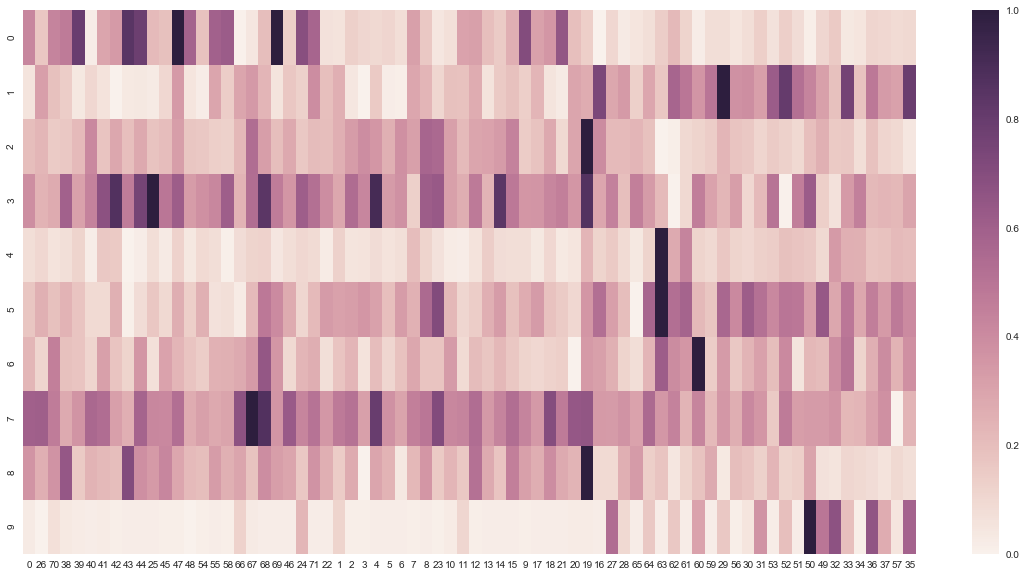

In [8]:
# select the top 10 features
effective_list = df_res.sort_values(by='abs fs weight', ascending=False).index[:10]

# combining train and test
df_all = pd.concat([train, test], axis=1)
df_all = df_all.loc[:, [e for e in df_all.columns if 'call' not in e]].drop(['Gene Description', 'Gene Accession Number'], axis=1).T
df_all.index = df_all.index.astype('int') - 1

# add label 'cancer' (take the value of all(=0) or aml(=1))
df_all['cancer'] = actual['cancer']
df_all = df_all.sort_index()

# extract features by effective_list
original = df_all.loc[:, effective_list]
scaler = MinMaxScaler().fit(original)
scaled = scaler.transform(original)
df_eff = pd.DataFrame(scaled)
df_eff['cancer'] = df_all['cancer']

#　visualize
df_eff = df_eff.sort_values(by='cancer')
df_eff_num = df_eff.drop('cancer', axis=1).T
plt.figure(figsize = (20,10))
sns.heatmap(df_eff_num)
plt.show()

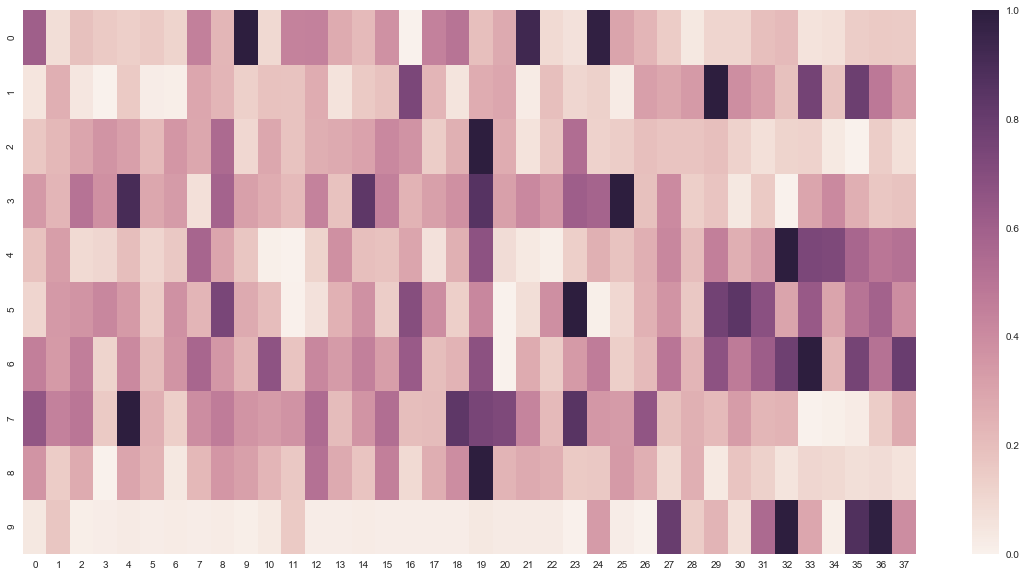

In [9]:
# check training data
df_tra = df_all[:38].loc[:, effective_list]

scaler = MinMaxScaler().fit(df_tra)
scaled_tra = scaler.transform(df_tra)
df_tra = pd.DataFrame(scaled_tra)
df_tra['cancer'] = df_all['cancer'][:38]

#　visualize
_ALL = df_tra[df_tra['cancer'] == 'ALL'].sort_index()
_AML = df_tra[df_tra['cancer'] == 'AML'].sort_index()
df_tra = pd.concat([_ALL, _AML])
df_tra_num = df_tra.drop('cancer', axis=1).T

plt.figure(figsize = (20,10))
sns.heatmap(df_tra_num)
plt.show()

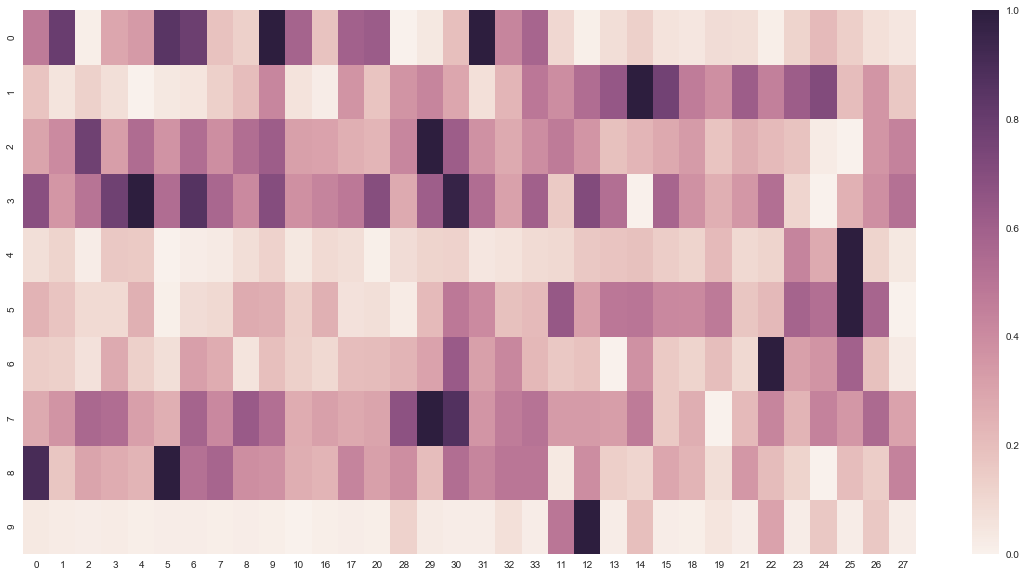

In [10]:
# check test data
df_test = df_all[38:].loc[:, effective_list]

scaler = MinMaxScaler().fit(df_test)
test_scaled = scaler.transform(df_test)
df_test = pd.DataFrame(test_scaled)
df_test['cancer'] = df_all['cancer'][38:].reset_index(drop=True)

_ALL = df_test[df_test['cancer'] == 'ALL'].sort_index()
_AML = df_test[df_test['cancer'] == 'AML'].sort_index()
df_test = pd.concat([_ALL, _AML])
df_test_num = df_test.drop('cancer', axis=1).T

plt.figure(figsize = (20,10))
sns.heatmap(df_test_num)
plt.show()

In [11]:
# classify by 10 features
x_red_train = df_eff.drop(['cancer'], axis=1).sort_index()[:38]
x_red_test  = df_eff.drop(['cancer'], axis=1).sort_index()[38:]

# normarize
scaler = MinMaxScaler()
scaler.fit(x_red_train)
x_red_train = scaler.transform(x_red_train)
x_red_test  = scaler.transform(x_red_test)
x_red_train = np.array(x_red_train).reshape(38, 10, 1)
x_red_test  = np.array(x_red_test).reshape(34, 10, 1)

In [12]:
# define reduce model
def reduce_model():
    model = Sequential()

    model.add(Flatten(input_shape=(10, 1)))
              
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.25))
    
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.25))
              
    model.add(Dense(2, activation='softmax'))
    model.compile(loss='categorical_crossentropy',
                  optimizer=Adam(),
                  metrics=['accuracy'])
    
    return model

In [13]:
red_model = reduce_model()
red_model.summary()
red_history = red_model.fit(x_red_train, y_train,
                            batch_size=38,
                            epochs=100,
                            verbose=0)
red_score   = red_model.evaluate(x_red_test, y_test, batch_size=34)
print("score : {}".format(red_score))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_52 (Flatten)         (None, 10)                0         
_________________________________________________________________
dense_154 (Dense)            (None, 32)                352       
_________________________________________________________________
dropout_103 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_155 (Dense)            (None, 32)                1056      
_________________________________________________________________
dropout_104 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_156 (Dense)            (None, 2)                 66        
Total params: 1,474
Trainable params: 1,474
Non-trainable params: 0
_________________________________________________________________
34/34 [=